last cell is the cell that is brought all together. other cells were learning and trying to understand the problem.

goal is to create pipeline to prediction model. create annuli, send to prediction, then reconstruct.

In [2]:
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.nddata.utils import Cutout2D
from astropy.coordinates import SkyCoord
from astropy import wcs

(512, 512)


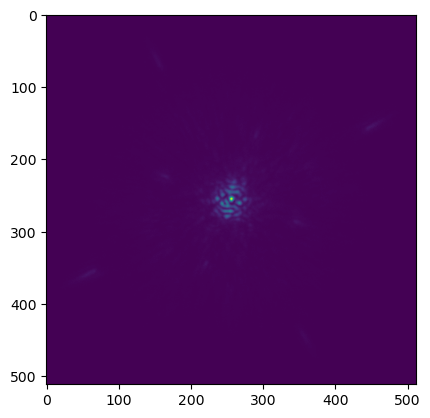

In [3]:
img = "C:\\Users\\snedd\\work\\project\\raw_images\\cen_camsci1_20230316015110794263351.fits"
header = fits.getheader(img)
data = np.array(fits.getdata(img), dtype= np.float32)

plt.imshow(data)
print(data.shape)
plt.show()


(512, 512)
max_index: 130816
coords of highest val: (255, 256)
image center: (256, 256)


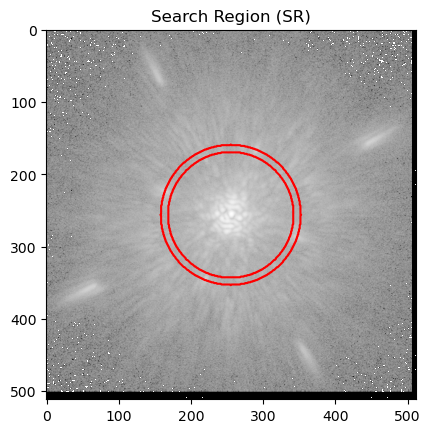

In [4]:
#Search Region(SR) define inner and out raduis

srPixInner = 87
srPixOuter =  97
#create a grid
#get center of the image
center = (data.shape[0]//2, data.shape[0]//2) #true center of image, but needs to be centered on the star. 
#star center
print(data.shape)
#find the index of max val
max_index = np.argmax(data)
print('max_index:', max_index)
#convert the flat index to tuple coords
star_center = np.unravel_index(max_index, data.shape)
print('coords of highest val:', star_center)
print("image center:", center)
#create a mesh grid of pixel coords
x,y = np.ogrid[:data.shape[0], :data.shape[1]]
distance_from_center = np.sqrt((x - center[1])**2 + (y-center[0])**2)
distance_from_star_center = np.sqrt((x- star_center[1])**2 + (y-star_center[0])**2 )
sr_mask = (distance_from_center >= srPixInner) & (distance_from_center <= srPixOuter)
sr_mask2 = (distance_from_star_center >= srPixInner) & (distance_from_star_center <= srPixOuter)
#print('sr_mask:', sr_mask)

#display SR
from matplotlib.colors import LogNorm
plt.imshow(data, cmap= 'gray', norm= LogNorm())
#plt.contour(sr_mask, colors= 'b')
plt.contour(sr_mask2, colors= 'r')
plt.title('Search Region (SR)')
plt.show()


### Define OR
Optimization Region is the wedge shaped region around the given search pixel. The inner and outer radius along with the half-angle are defined here

to make square will need to change the inner and outer radius to make it taller then change the ang to make it wider and crop into a square

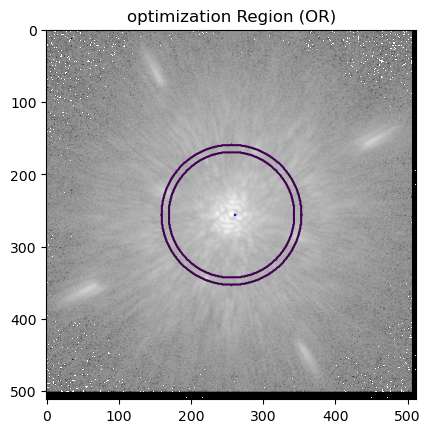

In [7]:
import math
#define the Optimization Region (OR)
orDPixInner = 5 #tall. closer to center (bottom)
orDPixOuter = 5 #outer radius larger than inner radius, farther (top)
orDPixAng = 22.5 # how wide to make the cut
psfHW = 2.5 # 'planet' mask

def wedge_mask(shape, center, inner_radius, outer_radius, angle_deg):
    y, x = np.ogrid[:shape[0], :shape[1]]
    #radian is definesd as the angle subtended at the center of a circle by an arc whose lenth is equal to the circle's radius. 
    angle_rad = math.radians(angle_deg)

    #calc distances and angles from center
    distance = np.sqrt((x- center[1])**2 + (y-center[0])**2)
    angle = np.arctan2(y-center[0], x- center[1])

    #normalize angles within range [0, 2*pi]
    angle = (angle + 2*np.pi) % ( 2 * np.pi)

    #define wedge mask
    mask = (distance >= inner_radius) & (distance <= outer_radius) & (angle <= angle_rad) & (angle >= -angle_rad)
    return mask

#define center of the wedge (typically the SR)
sp_center = center

#create the wedge mask for the optimizatio region
or_mask = wedge_mask(data.shape, sp_center, orDPixInner, orDPixOuter, orDPixAng)

plt.imshow(data, cmap= 'gray', norm = LogNorm())
plt.contour(or_mask, colors='b')
plt.contour(sr_mask)
plt.title('optimization Region (OR)')
plt.show()

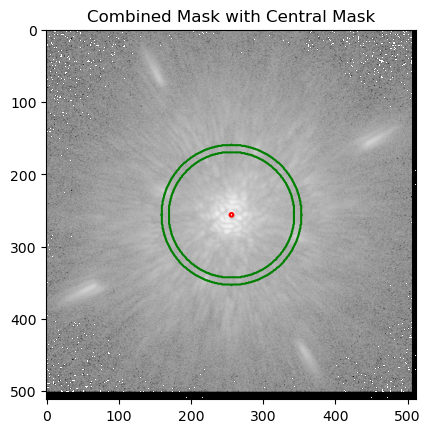

In [8]:
# Create the central mask
psf_radius = psfHW

# Mask for the central part (planet image)
central_mask = distance_from_center <= psf_radius

# Combine the masks (this step might vary depending on the exact requirements)
combined_mask = sr_mask & ~central_mask
#'~' not oporator. ensures that only the pixels within the search area are captured but not the central 'planet' mask

# Display the combined mask
plt.imshow(data, cmap='gray', norm=LogNorm())
plt.contour(combined_mask, colors='g')
plt.contour(central_mask, colors= 'r')
plt.title('Combined Mask with Central Mask')
plt.show()


In [ ]:
import sys
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from astropy.nddata.utils import Cutout2D
from astropy.coordinates import SkyCoord
from astropy import wcs
import math

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import sys
from astropy.io import fits

def create_wedge(shape, center, inner_radius, outer_radius, angle_deg):
    y, x = np.ogrid[:shape[0], :shape[1]]
    angle_rad = math.radians(angle_deg)
    
    # Calculate distances and angles from the center
    distance = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    angle = np.arctan2(y - center[0], x - center[1])
    
    # Normalize angles to be within the range [-pi, pi]
    angle = (angle + 2 * np.pi) % (2 * np.pi) - np.pi
    
    # Define the wedge mask
    mask = (distance >= inner_radius) & (distance <= outer_radius) & (angle <= angle_rad) & (angle >= -angle_rad)
    
    return mask

# Example usage with sample parameters
filename = "C:\\Users\\snedd\\astronomy_project\\project\\annuli_Wplanet\\raw_images\\cen_camsci1_20230316024607829066148.fits"
hdul = fits.open(filename)
data = hdul[0].data
hdul.close()

center = (data.shape[0] // 2, data.shape[1] // 2)  # assuming the center of the image
srPixInner = 87
srPixOuter = 97
orDPixInner = 5
orDPixOuter = 5
orDPixAng = 22.5
psfHW = 2.5

# Define the search region
y, x = np.ogrid[:data.shape[0], :data.shape[1]]
distance_from_center = np.sqrt((x - center[1])**2 + (y - center[0])**2)
sr_mask = (distance_from_center >= srPixInner) & (distance_from_center <= srPixOuter)

# Central mask
psf_radius = psfHW
central_mask = distance_from_center <= psf_radius
combined_mask = sr_mask & ~central_mask

# Create the wedge mask centered on the star
wedge_mask = create_wedge(data.shape, center, srPixInner, srPixOuter, orDPixAng)

# Intersect the wedge mask with the search region
final_mask = wedge_mask & combined_mask

# Extract the annuli
annuli = np.zeros_like(data)
annuli[final_mask] = data[final_mask]

# Plot the data with the masks
plt.imshow(data, cmap='gray', norm=LogNorm())
plt.contour(final_mask, colors='r')
plt.contour(sr_mask)
plt.show()
plt.imshow(annuli)


In [ ]:
from skimage import data
from skimage.transform import rotate
def rotate_image(image, degree):
    return rotate(image, degree)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import sys
from astropy.io import fits
from skimage import data
from skimage.transform import rotate

def rotate_image(image, degree):
    return rotate(image, degree)

def create_wedge(shape, center, inner_radius, outer_radius, angle_deg):
    y, x = np.ogrid[:shape[0], :shape[1]]
    angle_rad = math.radians(angle_deg)
    # Calculate distances and angles from the center
    distance = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    angle = np.arctan2(y - center[0], x - center[1])
    # Normalize angles to be within the range [-pi, pi]
    angle = (angle + 2 * np.pi) % (2 * np.pi) - np.pi
    # Define the wedge mask
    mask = (distance >= inner_radius) & (distance <= outer_radius) & (angle <= angle_rad) & (angle >= -angle_rad)
    return mask


filename = "C:\\Users\\snedd\\astronomy_project\\project\\annuli_Wplanet\\raw_images\\cen_camsci1_20230316024607829066148.fits"
hdul = fits.open(filename)
data = hdul[0].data
hdul.close()
print(f'image size: {data.size}')
print(f'data shape: {data.shape}')
print(f'center column: {512//2}')
center = (data.shape[0] // 2, data.shape[1] // 2)  # assuming the center of the image
srPixInner = 87#have these as an user input in the future
srPixOuter = 97 
orDPixInner = 5 #tall. closer to center (bottom)
orDPixOuter = 5 #outer radius larger than inner radius, farther (top)
orDPixAng = 22.5 # how wide to make the cut
psfHW = 2.5 # 'planet' mask

# Define the search region
y, x = np.ogrid[:data.shape[0], :data.shape[1]]
distance_from_center = np.sqrt((x - center[1])**2 + (y - center[0])**2)
sr_mask = (distance_from_center >= srPixInner) & (distance_from_center <= srPixOuter)

# Central 'planet' mask
psf_radius = psfHW
combined_mask = sr_mask & ~central_mask

# # Iterate over search region
# run =0
# for i in range(data.shape[0]):
#     for j in range(data.shape[1]):
#         if combined_mask[i, j]:
#             # Define the optimization region for each search pixel (SP)
#             or_mask = create_wedge(data.shape, center, orDPixInner, orDPixOuter, orDPixAng)
            
#             # Apply optimization region mask
#             final_mask = or_mask & combined_mask
            
#             # Extract the annuli
#             annuli = np.zeros_like(data)
#             annuli[final_mask] = data[final_mask]
            
#             # Plot the data with the masks
#             plt.imshow(data, cmap='gray', norm=LogNorm())
#             plt.contour(final_mask, colors='r')
#             plt.contour(or_mask, colors = 'b')
#             plt.contour(central_mask, colors='y')
#             plt.title(f"Optimization Region for Pixel ({i},{j})")
#             plt.contour(sr_mask)
#             plt.show()
#             plt.imshow(annuli)
#             plt.show()

#             # Exit after the first to test
#             if run >= 4:
#                 sys.exit()
#             run +=1
